In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [6]:
def generate_fishing_grounds(n_grounds = 10, x_max = 100, y_max = 100):
    return np.random.rand(n_grounds, 2) * np.array([x_max, y_max])

In [11]:
def generate_ships(n_ships = 10, x_max = 100, y_max = 100):
    return np.random.rand(n_ships, 2) * np.array([x_max, y_max])

In [12]:
grounds = generate_fishing_grounds()
ships = generate_ships()

In [21]:
def calculate_ship_distance_from_grounds(ships, grounds):
    return np.linalg.norm(ships[:, np.newaxis] - grounds, axis=2)

In [22]:
def calculate_ship_distance_from_ships(ships):
    return np.linalg.norm(ships[:, np.newaxis] - ships, axis=2)

array([False, False, False, False, False, False, False, False,  True,
        True])

In [16]:
distances = calculate_ship_distance_from_grounds(ships, grounds)

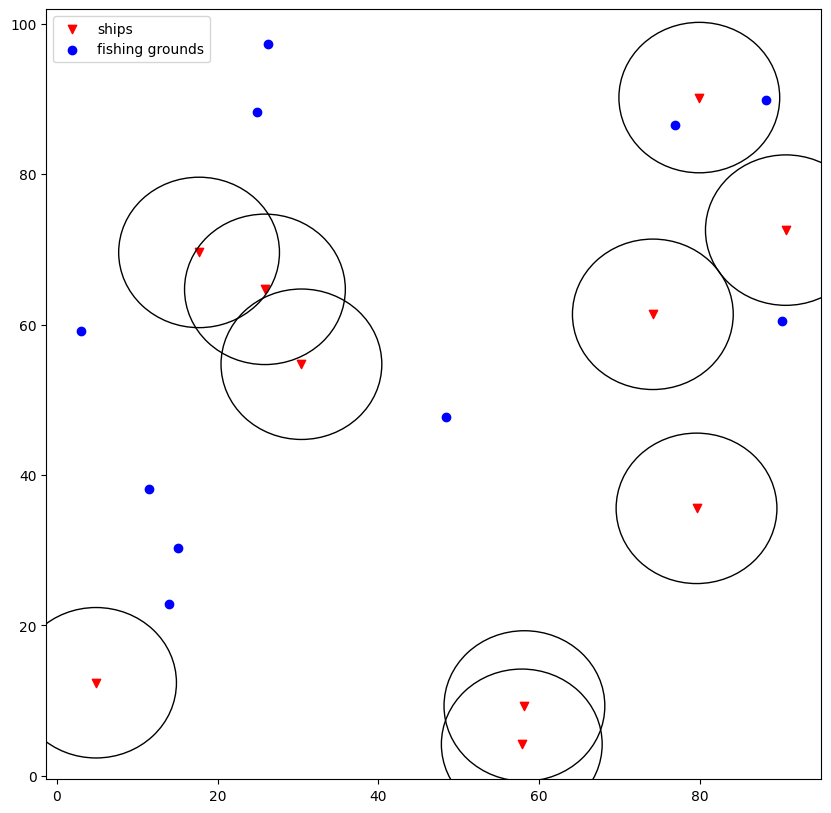

In [26]:
plt.figure(figsize=(10, 10))
# plot the ships and the fishing grounds
plt.scatter(ships[:, 0], ships[:, 1], c='red', label='ships', marker='v')
plt.scatter(grounds[:, 0], grounds[:, 1], c='blue', label='fishing grounds')

# add a circle around the ships with a given radius
radius = 10
for ship in ships:
    plt.gca().add_artist(plt.Circle(ship, radius, fill=False))


plt.legend()
plt.show()